# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-20 05:37:34--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  60.4MB/s    in 1.9s    

2022-09-20 05:37:36 (60.4 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [3]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32')

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

8173


Text(0.5, 1.0, 'G')

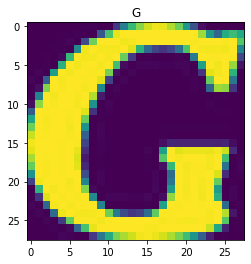

In [4]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18723)
print(i)
plt.imshow( X[i,:,:,0] )
plt.title( "ABCDEFGHIJ"[y[i]] )

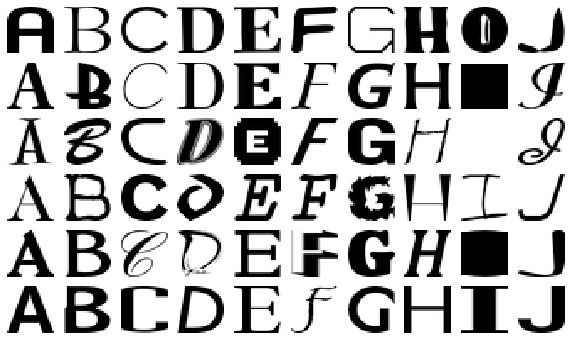

In [5]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [6]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [7]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

## X : Min-Max Scaling

In [8]:
max_n, min_n = x_train.max(), x_train.min()

x_train = (max_n - x_train) / (max_n - min_n)
x_test = (max_n - x_test) / (max_n - min_n)

## Y : One-Hot Encoding

In [9]:
from tensorflow.keras.utils import to_categorical

n_class = len(np.unique(y_train))
y_train = to_categorical(y_train, n_class) # 순서 주의
y_test = to_categorical(y_test, n_class)

In [10]:
y_train.shape, y_test.shape

((14979, 10), (3745, 10))

## Keras로 자유롭게 CNN 모델링

1. [이 구조를 미니 버전으로 활용해봐도 좋다](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
2. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

In [12]:
keras.backend.clear_session()

inputs = Input(shape=(28, 28, 1))
x = inputs

for size in [64, 128]:
  x = Conv2D(filters=size, kernel_size=(3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=size, kernel_size=(3, 3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Early Stopping을 이용한 학습

1. validation_split = 0.2
2. 1 epoch 돌려가며 빠르게 학습되는 batch_size를 찾을 것
3. 5 epoch 전보다 val_loss가 개선되지 않았으면 멈추는 얼리스토핑

In [13]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

In [14]:
history = model.fit(x_train, y_train, verbose=1, validation_split=.2, callbacks=[es], epochs=100)

Epoch 1/100
375/375 [==============================] - 19s 12ms/step - loss: 0.4521 - accuracy: 0.8712 - val_loss: 0.9099 - val_accuracy: 0.7820
Epoch 2/100
375/375 [==============================] - 4s 11ms/step - loss: 0.2272 - accuracy: 0.9344 - val_loss: 0.2631 - val_accuracy: 0.9322
Epoch 3/100
375/375 [==============================] - 4s 11ms/step - loss: 0.1927 - accuracy: 0.9418 - val_loss: 0.2691 - val_accuracy: 0.9279
Epoch 4/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1557 - accuracy: 0.9537 - val_loss: 0.3138 - val_accuracy: 0.9269
Epoch 5/100
375/375 [==============================] - 4s 10ms/step - loss: 0.1459 - accuracy: 0.9564 - val_loss: 0.2774 - val_accuracy: 0.9316
Epoch 6/100
375/375 [==============================] - 4s 11ms/step - loss: 0.1178 - accuracy: 0.9640 - val_loss: 0.2634 - val_accuracy: 0.9342
Epoch 7/100
375/375 [==============================] - 4s 11ms/step - loss: 0.1151 - accuracy: 0.9645 - val_loss: 0.2516 - val_accuracy

* 예측값 생성

In [15]:
y_pred = model.predict(x_test)

* 생성한 예측값을 y_test 구조와 같게 만든다

In [16]:
pred_array = np.zeros(shape=(y_pred.shape[0], y_pred.shape[1]))
idx = 0

for arr_val in y_pred :
    # print(arr_val)
    pred_array[idx][arr_val.argmax()] = 1
    idx += 1

In [17]:
pred_array.shape

(3745, 10)

* 성능 평가

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
print( f'{accuracy_score(y_test, pred_array):.4f}' )

0.9469


## 문자 이미지 시각화

In [20]:
import random as rd

In [21]:
character = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

* 실제 성능 확인을 위해 반복 실행!

id = 1200
실제 문자 : E
모델의 문자 예측 : E
모델의 문자별 예측 확률 : [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]
정답


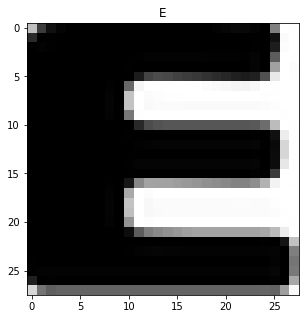

In [22]:
rand_n = rd.randrange(0, 3744)

print(f'id = {rand_n}')
print(f'실제 문자 : {character[y_test[rand_n].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[rand_n].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[rand_n]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[rand_n].argmax() == y_pred[rand_n].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[rand_n].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_test[rand_n].argmax()] )
plt.show()

* 틀린 문자만 확인해봅시다!

id = 3492
실제 문자 : D
모델의 문자 예측 : G
모델의 문자별 예측 확률 : [ 3.  5. 26.  2. 12.  5. 33.  2.  7.  5.]
오답


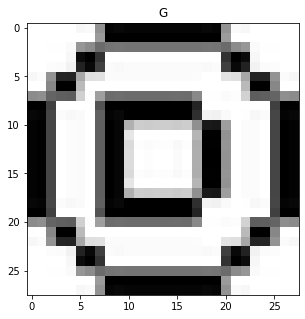

In [23]:
t_f = ( y_test.argmax(axis=1) == y_pred.argmax(axis=1) )
false_id = np.where(t_f==False)[0]
false_n = len(false_id)

id = false_id[rd.randrange(0, false_n)]

print(f'id = {id}')
print(f'실제 문자 : {character[y_test[id].argmax()]}')
print(f'모델의 문자 예측 : {character[y_pred[id].argmax()]}' )
print(f'모델의 문자별 예측 확률 : {np.round(y_pred[id]*100)}')
# print(f'모델의 문자들 총 확률 : {sum(np.round(y_pred[rand_n]*100))}')

print('====================================================')

if y_test[id].argmax() == y_pred[id].argmax() :
    print('정답')
else :
    print('오답')

print('====================================================')

plt.figure(figsize=(5,5))
plt.imshow(x_test[id].reshape(28, 28), cmap='gray')
plt.title("ABCDEFGHIJ"[y_pred[id].argmax()] )
plt.show()